Epoch 1/10
2/2 [==============================] - 3s 936ms/step - loss: 1.1693 - accuracy: 0.3725 - val_loss: 0.6740 - val_accuracy: 0.5385
Epoch 2/10
2/2 [==============================] - 2s 1s/step - loss: 0.7052 - accuracy: 0.4118 - val_loss: 0.6888 - val_accuracy: 0.4615
Epoch 3/10
2/2 [==============================] - 3s 1s/step - loss: 0.6816 - accuracy: 0.4706 - val_loss: 0.6728 - val_accuracy: 0.6154
Epoch 4/10
2/2 [==============================] - 3s 1s/step - loss: 0.6735 - accuracy: 0.6471 - val_loss: 0.6529 - val_accuracy: 0.7692
Epoch 5/10
2/2 [==============================] - 2s 669ms/step - loss: 0.6498 - accuracy: 0.8627 - val_loss: 0.6106 - val_accuracy: 0.7692
Epoch 6/10
2/2 [==============================] - 2s 733ms/step - loss: 0.6218 - accuracy: 0.7843 - val_loss: 0.5622 - val_accuracy: 0.7692
Epoch 7/10
2/2 [==============================] - 2s 705ms/step - loss: 0.5467 - accuracy: 0.8039 - val_loss: 0.5066 - val_accuracy: 0.7692
Epoch 8/10
2/2 [=============

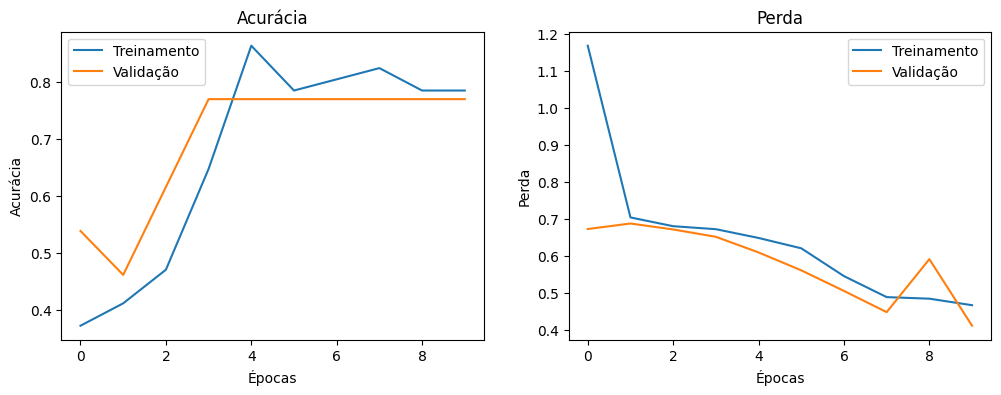

In [21]:

# Função para carregar e pré-processar imagens
def load_images_from_folder(folder_path, image_size=(128, 128)):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertendo de BGR para RGB
            images.append(img)
    return np.array(images)

# Função para carregar e pré-processar uma imagem usando OpenCV
def load_and_preprocess_image(image_path, image_size=(128, 128)):
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.resize(img, image_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertendo de BGR para RGB
        img = np.expand_dims(img, axis=0)  # Adicionando uma dimensão para o batch
    return img

# Definir caminhos para os diretórios contendo as imagens
laranja_folder_path = '/content/drive/MyDrive/Colab Notebooks/Laranjas'
not_laranja_folder_path = '/content/drive/MyDrive/Colab Notebooks/Tangerinas'

# Carregar imagens das pastas
laranja_images = load_images_from_folder(laranja_folder_path)
not_laranja_images = load_images_from_folder(not_laranja_folder_path)

# Criar labels (1 para laranja, 0 para não laranja)
laranja_labels = np.ones(len(laranja_images))
not_laranja_labels = np.zeros(len(not_laranja_images))

# Combinar dados e labels
X = np.concatenate((laranja_images, not_laranja_images), axis=0)
y = np.concatenate((laranja_labels, not_laranja_labels), axis=0)

# Dividir o conjunto de dados em treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os valores dos pixels
X_train = X_train / 255.0
X_val = X_val / 255.0

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Definir o modelo
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Para classificação binária
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinamento do modelo com data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_val, y_val), epochs=10)

# Salvar o modelo treinado
model.save('/content/saved_model.h5')

# Plotar a acurácia e a perda do treinamento e validação
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.show()

1/1 [==============================] - 0s 92ms/step
A imagem não é de uma laranja.


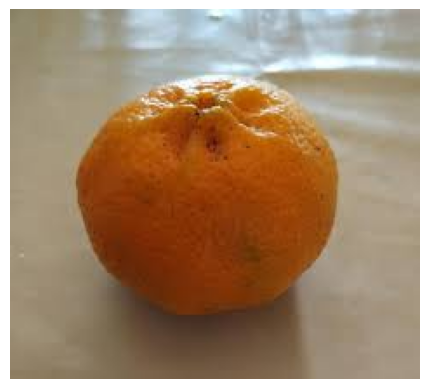

In [24]:

import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Função para carregar e pré-processar uma imagem usando OpenCV
def load_and_preprocess_image(image_path, image_size=(128, 128)):
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.resize(img, image_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertendo de BGR para RGB
        img = img / 255.0  # Normalizar os valores dos pixels
        img = np.expand_dims(img, axis=0)  # Adicionar uma dimensão para o batch
    return img

# Função para carregar o modelo e fazer predições
def predict_image(model, image_path):
    # Carregar e pré-processar a imagem
    img = load_and_preprocess_image(image_path)

    # Fazer a predição
    prediction = model.predict(img)

    # Interpretar a predição
    if prediction[0] > 0.5:
        print("A imagem é de uma laranja.")
    else:
        print("A imagem não é de uma laranja.")

    # Exibir a imagem
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Defina o caminho para a imagem de teste
test_image_path = '/content/images (1).jpeg'

# Carregar o modelo treinado
model = tf.keras.models.load_model('/content/saved_model.h5')

# Fazer a predição na imagem de teste
predict_image(model, test_image_path)